In [364]:
"""
chain stoichiometric reactions together a la factorio / space chem / dwarf fortress

 - code
 --construct steps
 --simulate outputs
 --backcalculate required reagents?
 
 - graphics (simple text visualizer?)
 - export to DF token file


considerations:

-are reactions only allowed to be DAGs? Trees?

need a string parser?
e.g. specify reaction as (A + 2*B | C) => (3*D + E | C)



What order to calculate nodes in?? 
Topological Sort! Since it's a DAG

Topological Sort – Recursive Algorithm based on DFS dmarino notes
https://en.wikipedia.org/wiki/Topological_sorting
https://stackoverflow.com/questions/54903222/implementing-a-dag-in-python
dags in python, use networkx

https://docs.google.com/drawings/d/1Ibpgsd2GGnHsR-sVRLXnB0J9q5j_s7IKJyRprAumhJU/edit


........

Have outputs be Counter dictionaries? because then they can be added, subtracted :)
https://docs.python.org/2/library/collections.html#collections.Counter


[TODO]
    have separate 
    add nonconsumed inputs
    
Counters are a bad idea? might want non integer amounts at somepoint


if/while Src.Stores > Rec.input_reqs
    Rec.inStores += Src.sendStores(Rec.input_reqs)
    Rec.outStores = Rec.IO() #queues outputs ready to be received
    
    
    #AHA! only conversion should be conditional? accept inputs always

"""
from collections import Counter
from math import inf
import networkx as nx

In [365]:
def nullCounter(c):
    return Counter({x:0 for x in c})

def CounterGTOE(c1:Counter, c2:Counter):
    diffC = c1.copy()
    diffC.subtract(c2)
    return all( (dc>=0) for dc in diffC.values())

def AnyCounterGTOE(c1:Counter, c2:Counter):
    diffC = c1.copy()
    diffC.subtract(c2)
    return any( (dc>=0) for dc in diffC.values())

def getCoeff(s):
    #assumes input is either 5*A or B
    coeff_name = s.split('*')
    if len(coeff_name) > 1:
        d = {coeff_name[1]: int(coeff_name[0])}
    else:
        d = {coeff_name[0]:1} if coeff_name[0] else {}
    return d
    
    
def parse(s):
    LR = s.split('=>')
    L = LR[0]
    R = LR[1]
    
    Largs = L.strip().split('+')
    Rargs = R.strip().split('+')
    
    Ldict = Counter()
    Rdict = Counter()
    
    for arg in Largs:
        c = getCoeff(arg)
        if c: Ldict.update(c)
           
    for arg in Rargs:
        c = getCoeff(arg)
        if c: Rdict.update(c)
    return Ldict, Rdict


restr = '2*A+B=>Z'
parse(restr)

(Counter({'A': 2, 'B': 1}), Counter({'Z': 1}))

In [366]:
[z,zz]=parse(restr)
for c in z:
    print(z[c])

2
1


In [367]:
def coeffs2dfToken(coeffs,isProduct=False, tags=':NONE:NONE:NONE:NONE]'):
#    prefix = ('[PRODUCT:' if isProduct else '[REAGENTS:')
    dfStr_list = []
    
    for c in coeffs:
        if isProduct:
            dfStr = '[PRODUCT:100:'+str(coeffs[c])+tags
        else:
            dfStr = '[REAGENT:'+c+':'+str(coeffs[c])+tags
        dfStr_list.append(dfStr)
    return dfStr_list
  
print(coeffs2dfToken(z))
print(coeffs2dfToken(zz,True))

    

['[REAGENT:A:2:NONE:NONE:NONE:NONE]', '[REAGENT:B:1:NONE:NONE:NONE:NONE]']
['[PRODUCT:100:1:NONE:NONE:NONE:NONE]']


In [368]:
class ReactionStage:
    name = 'stage 1'
    reactionStr = 'A => Z'
    #srcStr = ' => A'
    #recStr = 'Z => '
    
    
    def __init__(self, name:str, reactionStr:str):
        self.name = name
        self.reactionStr = reactionStr
        self.inputStageList = set()
        self.outputStageList = set()
        
        [self.in_coeffs,  self.out_coeffs] = parse(reactionStr)
        self.in_stores = nullCounter(self.in_coeffs)
        self.out_stores = nullCounter(self.out_coeffs)

        self.receive_thr = self.in_coeffs #this should actually be in_coeffs
        
    def addSource(self, source):
        self.inputStageList.add(source)

    def hasSources(self):
        return bool(self.inputStageList)
    
    def printSources(self):
        if self.hasSources():
            for src in self.inputStageList:
                print(self.name+' has '+src.name+' as a source')
            print(self.name+' has '+str(len(self.inputStageList))+' sources')
        else:
            print(self.name+' has no sources')
            
    def printStores(self):
        print(self.name+' has '+ str(self.in_stores) + ' and ' + str(self.out_stores))
    
    def printDFTokens(self):
        print(coeffs2dfToken(self.in_coeffs))
        print(coeffs2dfToken(self.out_coeffs , True))
    
    def convert(self, doPrint=False):
        if CounterGTOE(self.in_stores, self.in_coeffs):
            self.in_stores -= self.in_coeffs
            self.out_stores += self.out_coeffs 
            
    def __send(self, receive_thr, doPrint=False):
        to_be_sent = self.out_coeffs
        output = nullCounter(to_be_sent)
        if CounterGTOE(self.out_stores, to_be_sent):   
            #!!! Actually want to to send out_coeffs
            self.out_stores -= to_be_sent
            output += to_be_sent
            if doPrint: print(self.name+' sent '+str(output))
        else:
            output = nullCounter(receive_thr)
            if doPrint: print(self.name+' didnt send')

        return output
    
    def receiveFrom(self,other, doPrint=False):
        self.in_stores += other.__send(self.receive_thr, )
    
    def requestFromUpstream(self):
        if self.hasSources():
            for src in self.inputStageList:
                self.receiveFrom(src)
                
        return self.hasSources()
    '''
    def chainBacktrace(self):
        if self.hasSources():
            for src in self.inputStageList:
                src.chainBacktrace()
                print('spawned bt from'+self.name)
            self.requestFromUpstream()
    '''
#END reactionStage def

class ReactionSource(ReactionStage):
    name = '100*A'
    def __init__(self, name:str, initialVal=inf):
        self.name = name
        reactionStr = '=>'+name
        
        [self.in_coeffs,  self.out_coeffs] = parse(reactionStr)
        self.in_stores = Counter({x:0 for x in self.in_coeffs}) 
        self.out_stores = Counter({x:initialVal for x in self.out_coeffs}) 
        
        self.inputStageList = set()
        
    def printDFTokens(self, doReSort=False):
        print('no token, because source')     
        
    def convert(self, doPrint=False):
        True==False;

class ReactionSink(ReactionStage):
    name = 'Z'
    def __init__(self, name:str):
        self.name = name

        reactionStr = name+'=>'
        [self.in_coeffs,  self.out_coeffs] = parse(reactionStr)
        self.in_stores = nullCounter(self.in_coeffs)
        self.out_stores = nullCounter(self.out_coeffs) 
        self.receive_thr = Counter({name:-inf})       
        
        self.inputStageList = set()
        self.outputStageList = set()
        
    def printDFTokens(self, doReSort=False):
        print('no token, because sink')

    def convert(self, doPrint=False):
#        self.in_stores = self.in_coeffs;
        True==False;

    def receive(self,inChannel):
        print(name+'received somehting')
        stores += inChannel

    

In [381]:
    
class ReactionChain:

    def __init__(self):
        self.mySources = set()
        self.myReceivers = set()
        self.nodes = set()
        self.topoList = set()
        self.DAG = nx.DiGraph()
    
    def connect(self, sources, receivers):
        for source in sources:
            for rec in receivers:
                rec.addSource(source)
                self.DAG.add_node(source.name, data=source)
                self.DAG.add_node(rec.name, data=rec)
                self.DAG.add_edges_from([(source.name, rec.name)])

        self.mySources.add(sources)
        self.myReceivers.add(receivers)
        self.sortGraph()
        
    def sortGraph(self):    
        self.sortedNodes = nx.topological_sort(self.DAG)
        self.sortedEdges = list(nx.topological_sort(nx.line_graph(self.DAG)))
        
    def nodeData(self, nodeName):
        return dict(self.DAG.nodes[nodeName])['data']
    
    def plotGraph(self):
        #print(self.DAG.adj)
        nx.draw_networkx(self.DAG,node_color=[[.5,1,.5]])

    def stepChain(self, doPrint=False):
        self.sortGraph()
        
        for edge in self.sortedEdges:
            src = self.nodeData(edge[0])
            rec = self.nodeData(edge[1])
            src.convert(doPrint)
            rec.receiveFrom(src, doPrint)
            
    def printDFTokens(self, doReSort=False):
        if doReSort:
            self.sortGraph()
        for nodeName in self.sortedNodes:
            print('\n\n[OBJECT:REACTION]')
            print('[REACTION:'+nodeName+']')

            nodeVal = self.nodeData(nodeName)
            nodeVal.printDFTokens();

    def printChainVals(self,doReSort=False):
        if doReSort:
            self.sortGraph()
        for nodeName in self.sortedNodes:
            print('NODE:'+nodeName)
            nodeVal = self.nodeData(nodeName)
            print(' ' +str(nodeVal.in_stores))
            print(' ' +str(nodeVal.out_stores))
            



[OBJECT:REACTION]
[REACTION:D]
no token, because source


[OBJECT:REACTION]
[REACTION:B]
no token, because source


[OBJECT:REACTION]
[REACTION:A]
no token, because source


[OBJECT:REACTION]
[REACTION:Wither leaves]
['[REAGENT:A:1:NONE:NONE:NONE:NONE]', '[REAGENT:B:2:NONE:NONE:NONE:NONE]']
['[PRODUCT:100:5:NONE:NONE:NONE:NONE]']


[OBJECT:REACTION]
[REACTION:Roll leaves]
['[REAGENT:C:1:NONE:NONE:NONE:NONE]', '[REAGENT:D:1:NONE:NONE:NONE:NONE]']
['[PRODUCT:100:1:NONE:NONE:NONE:NONE]']


[OBJECT:REACTION]
[REACTION:Z]
no token, because sink


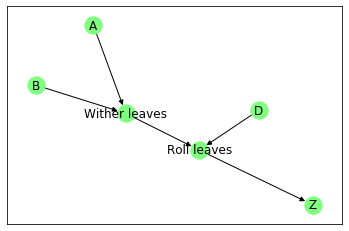

In [388]:
#test basics of stages

rA = ReactionSource('A',30)
rB = ReactionSource('B',100)
rD = ReactionSource('D',100)

rProcess = ReactionStage('Wither leaves','A+2*B=>5*C')
rP2 = ReactionStage('Roll leaves','C+D=>Z')

rZ = ReactionSink('Z')


Chain = ReactionChain()
Chain.connect(tuple([rA,rB]),tuple([rProcess]) )
Chain.connect(tuple([rProcess, rD]),tuple([rP2]) )

Chain.connect( tuple([rP2]), tuple([rZ]))
Chain.plotGraph()

Chain.printDFTokens()


In [371]:
Chain.printChainVals()
print('- Starting Sim -\n')
for i in range(100):
    Chain.stepChain()
    
Chain.printChainVals()

- Starting Sim -

NODE:B
 Counter()
 Counter()
NODE:A
 Counter()
 Counter()
NODE:StageUno
 Counter({'B': 40})
 Counter()
NODE:Z
 Counter({'Z': 150})
 Counter()


In [372]:
#rZ.chainBacktrace()